In [63]:
import pickle as pk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sys import path
path.append('..')
from clearsky.main import IterativeClearSky

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data 

In [211]:
# Run the script to get the data if it hasn't already been pickled
# To change what data you get, go into the script and change the START_DATE
# and END_DATE values near the top of the script
# exec(open('./tutorial_data_setup.py').read())

# If the script has already been run, data is saved locally, so load it
full_data = pk.load( open( "data/tutorial_data_no_leap.pkl", "rb" ) )

# Get just the columns that are solar generation
data = full_data['gen'][['solar_home1', 'solar_home2', 'solar_home3', 'solar_home4']][:-1]

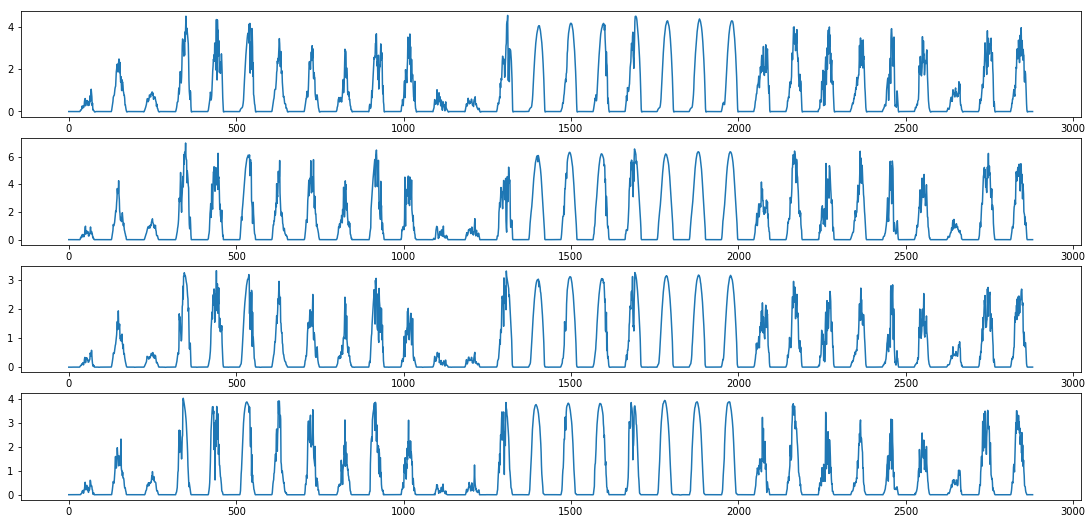

In [212]:
# Take a look at some of the data
plt.figure(figsize=(19,9))
for i in range(1,5):
    plt.subplot(4,1,i)
    plt.plot(data['solar_home' + str(i)].values[:30*N])

plt.show();

# Fitting Clearsky Model

Todo: try changing the $k$ argument in IterativeClearSky

In [36]:
# Define some constants
N = 96 # number of intervals in a day
num_homes = 4
num_days = int(len(site_data)/N)

In [150]:
# Now, fit the clearsky model to each site, then subtract that from the baseline, and put them all in one matrix

ics_vec = [] # vector of ICS objects
delta_data = np.zeros((N, num_days*num_homes)) # the data with the clearsky subtracted out
raw_data = np.zeros_like(delta_data) # data matrix of original data, for reference

# For each site:
for i in range(num_homes):
    site_str = 'solar_home' + str(i+1)
    site_data = data[site_str].values
    
    # Split the data for the site up into daily intervals along columns
    site_mat = np.reshape(site_data, (N, num_days), 'F')
    
    # Add to the raw_data matrix
    raw_data[:, i*num_days:(i+1)*num_days] = site_mat

    # Get the clearsky model for that site
    ics = IterativeClearSky(site_mat, k=4)
    ics.minimize_objective(verbose=False)
    ics_vec.append(ics)
    
    # Get what the clearsky model prediction is
    csky_mat = (ics.L_cs.value @ ics.R_cs.value)
    
    # Subtract the clearsky model from the actual data
    delt_mat = site_mat - csky_mat
    
    # Add the delt_data to the matrix to keep track of all delt_data
    delta_data[:, i*num_days:(i+1)*num_days] = delt_mat
    
    print('Iter complete')

Iter complete
Iter complete
Iter complete
Iter complete


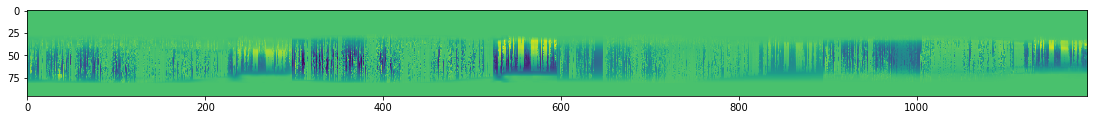

In [43]:
plt.figure(figsize=(19,10))
plt.imshow(delta_data)
plt.show()

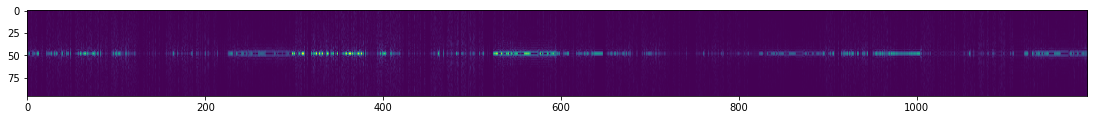

In [61]:
freq_data = np.fft.fftshift(np.fft.fft(delta_data, axis=0), axes=0)
plt.figure(figsize=(19,10))
plt.imshow(np.abs(freq_data))
plt.show()

# Clustering
Now, create a pipeline of clustering for the columns, and apply it to both the raw data and the data in the frequency domain

## PCA

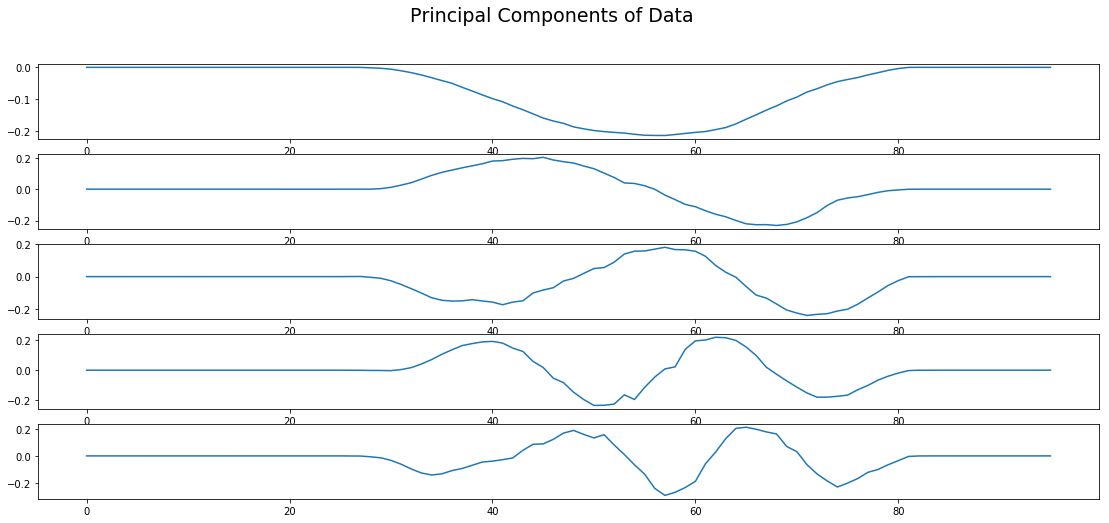

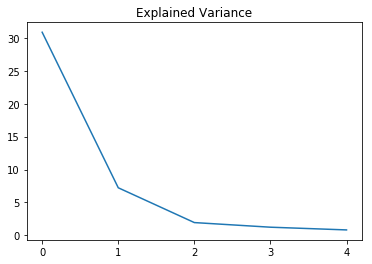

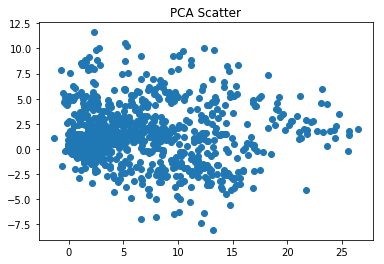

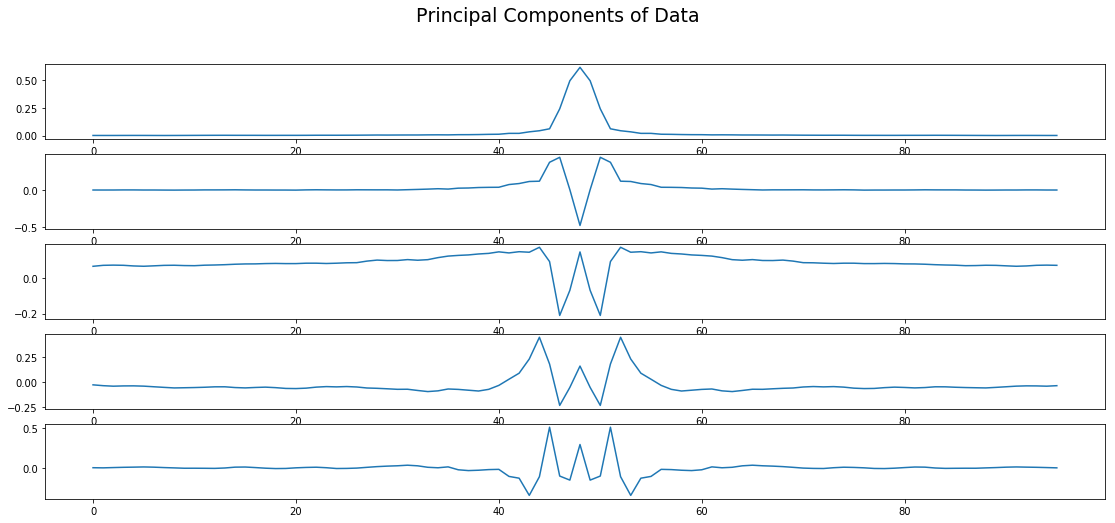

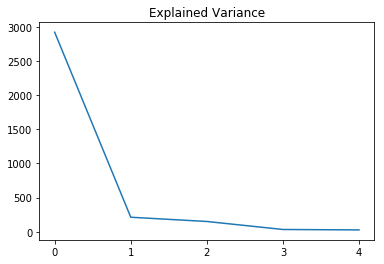

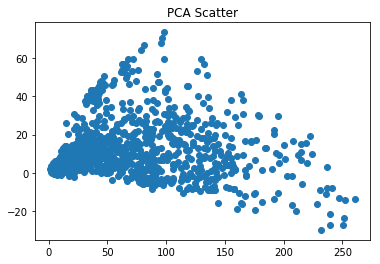

In [96]:
def do_pca(n_comp, data, plot=True):
    '''
    Plot the principal components, their explained variance, and a scatter of the data projected
    onto the top 2 components.
    
    data is shape (n_features, n_data_points)
    '''
    pca = PCA(n_components=n_comp)
    if np.iscomplex(data).any():
        pca.fit(np.abs(data.T))
    else:
        pca.fit(data.T)
    
    if plot:
        plt.figure(figsize=(19,6))
        for i in range(n_comp):
            plt.subplot(n_comp, 1, i+1)
            plt.plot(pca.components_[i, :])


        plt.suptitle('Principal Components of Data', fontsize=19);
        plt.show();

        plt.figure()
        plt.plot(pca.explained_variance_)
        plt.xticks(range(n_comp))
        plt.title('Explained Variance')
        plt.show()

        plt.figure()
        if np.iscomplex(data).any():
            proj_data = pca.components_[:2, :] @ np.abs(data)
        else:
            proj_data = pca.components_[:2, :] @ data
        plt.scatter(proj_data[0,:], proj_data[1,:])
        plt.title('PCA Scatter')
        plt.show()
    
    return pca, proj_data

delta_pca, delta_proj = do_pca(5, delta_data)
freq_pca, freq_proj = do_pca(5, freq_data)

## K-Means

So it actually looks like Kmeans does a pretty good job of finding samples that have similar shape to each other, both when using the time domain as well as frequency domain data. However, it also seems to have a very strong tendency to cluster together days that have similar heights, not just shapes, meaning many clear days still end up in different clusters if they have different heights, and also that clear days and overcast days still end up in the same cluster when they have similar height.

Fortunately, this tendency seems less prevalant when the clustering is done on the magnitude of the tranformed data, although it's still not perfect.

Also, in both cases, it seems like having more clusters let's the algorithm really identify some consistent clusters pretty well. As in, it'll find a nice cluster of many days that look very similar to each other, while other clusters will be more of the 'leftovers' cluster, which are more mixed bags.

In [98]:
from sklearn.cluster import KMeans

In [162]:
def do_kmeans(data, proj_data, n_clust_range=range(4,9), plot=True, plot_raw_data=False):
    '''
    Run kmeans on the data, using each value in n_clust_range as the number of clusters to try.
    Then, plot the centroids, the PCA scatter with labels according to the clustering, and random
    samples of the data from each cluster
    
    data is of shape (n_features, n_data_points), so cols are days and rows are time intervals
    
    For plotting, if plot_raw_data is true, the plots of samples from each cluster will be plots
    of the raw data (data without clearsky subtracted out)
    If plot_raw_data is false, then the samples plotted from each cluster will have the clearsky
    estimate subtracted out (i.e. it'll plot the delta_data instead)
    '''
    if np.iscomplex(data).any():
        data = np.abs(data)

    for n_clust in n_clust_range:
        kmeans = KMeans(n_clusters=n_clust).fit(data.T)

        # Plot the centroids
        plt.figure(figsize=(19,4))
        for i in range(n_clust):
            plt.subplot(n_clust, 1, i+1)
            plt.plot(kmeans.cluster_centers_[i,:])

        plt.suptitle('Cluster Centroids K = ' + str(n_clust))
        plt.show()

        # PCA scatter with colored labels
        plt.figure()
        plt.scatter(proj_data[0,:], proj_data[1,:], c=kmeans.labels_)
        plt.title('PCA Scatter with Kmeans Labels K = ' + str(n_clust))
        plt.show()

        # Plot some random samples from each cluster
        plt.figure(figsize=(19,8))
        for i in range(n_clust):
            clust = np.argwhere(kmeans.labels_ == i).squeeze()
            samps = np.random.choice(clust, size=10, replace=False)
            if plot_raw_data:
                concat_samps = np.array([raw_data[:, s] for s in samps])
            else:
                concat_samps = np.array([delta_data[:, s] for s in samps])
            plt.subplot(n_clust, 1, i+1)
            plt.plot(concat_samps.ravel())
        plt.suptitle('Cluster Samples K = ' + str(n_clust), fontsize=14)
        plt.show()

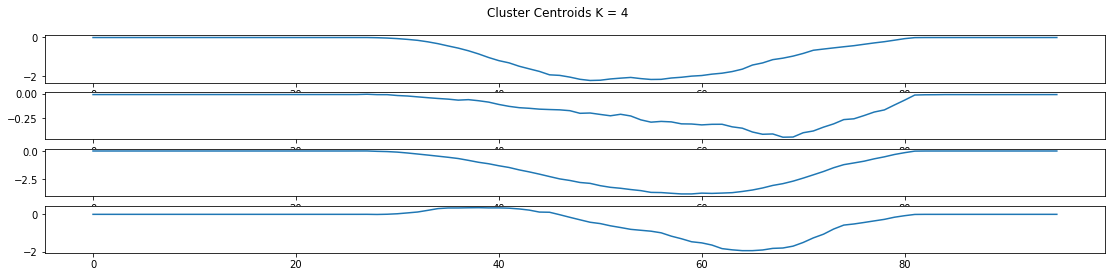

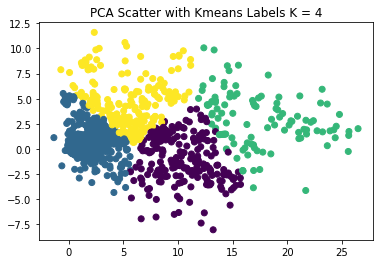

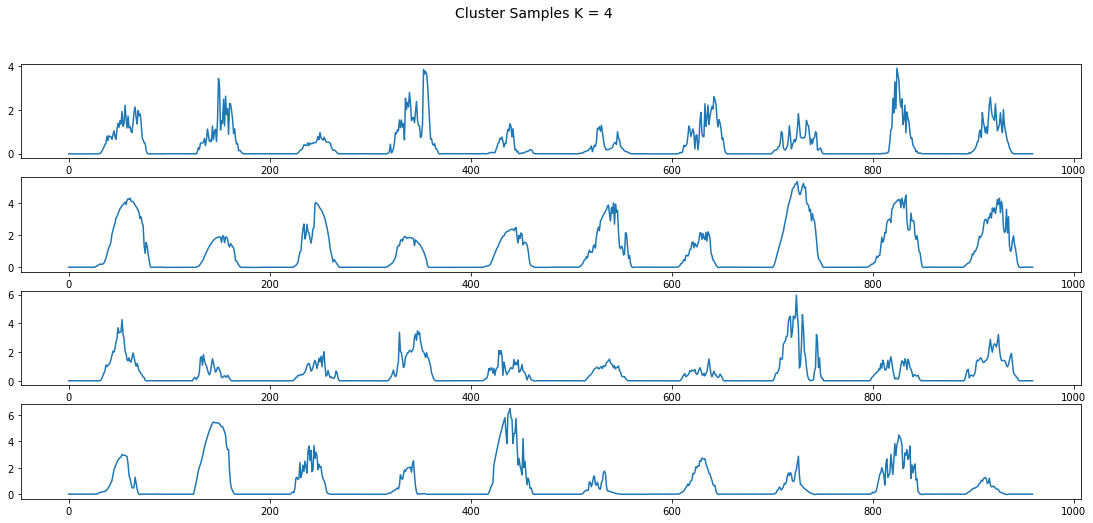

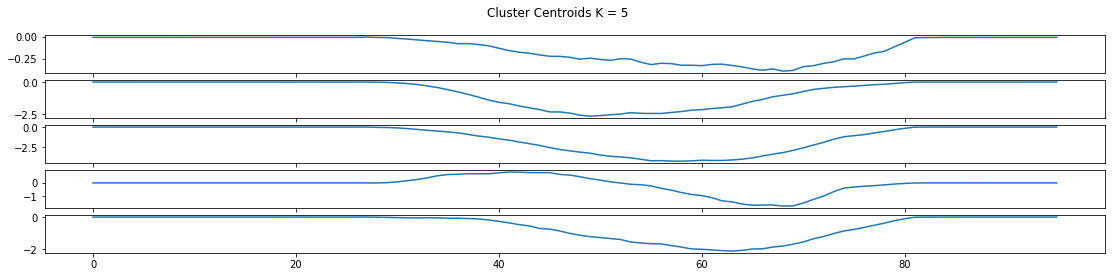

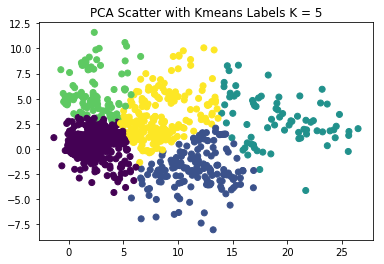

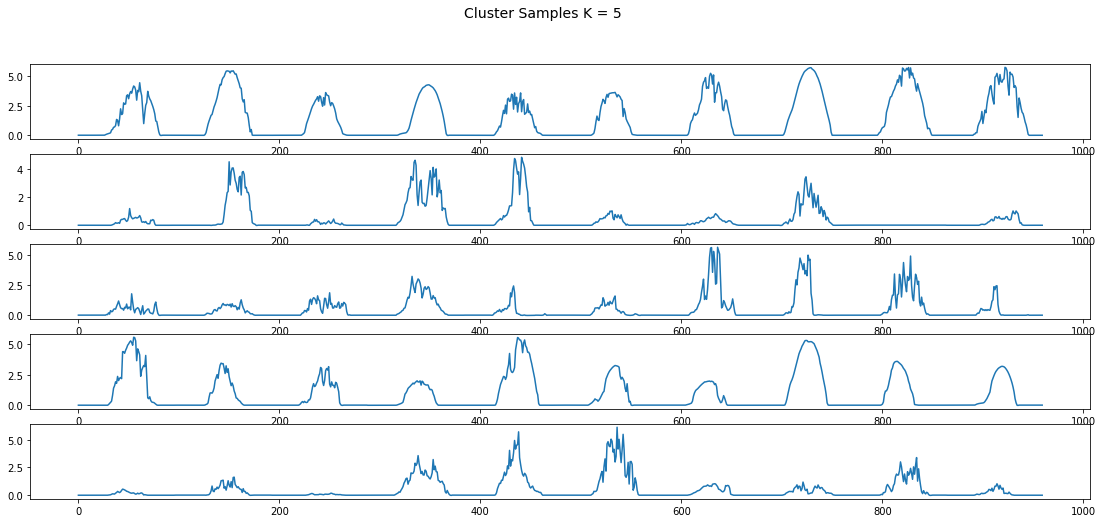

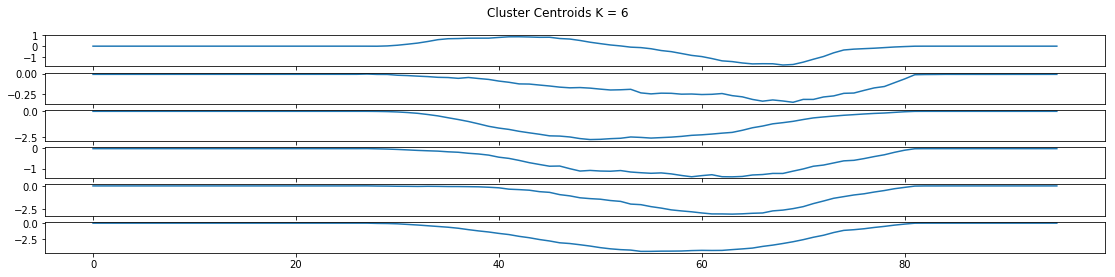

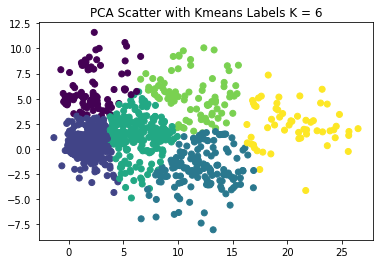

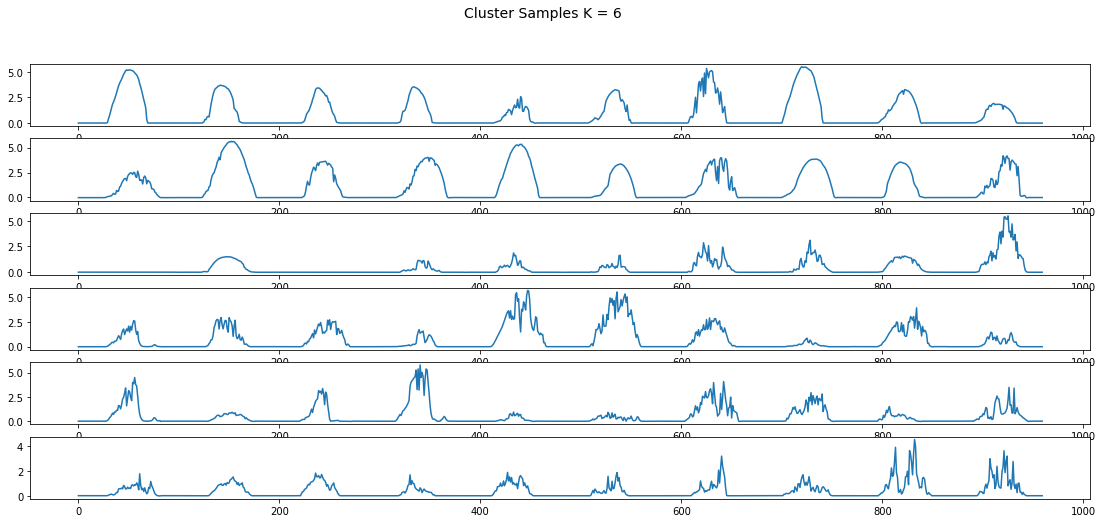

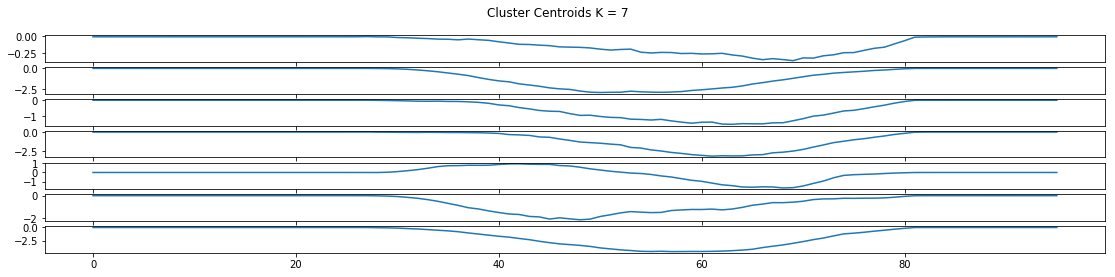

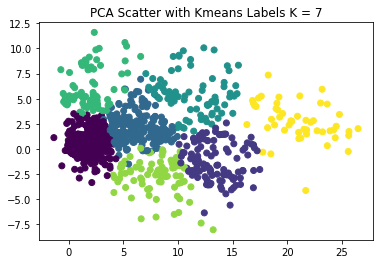

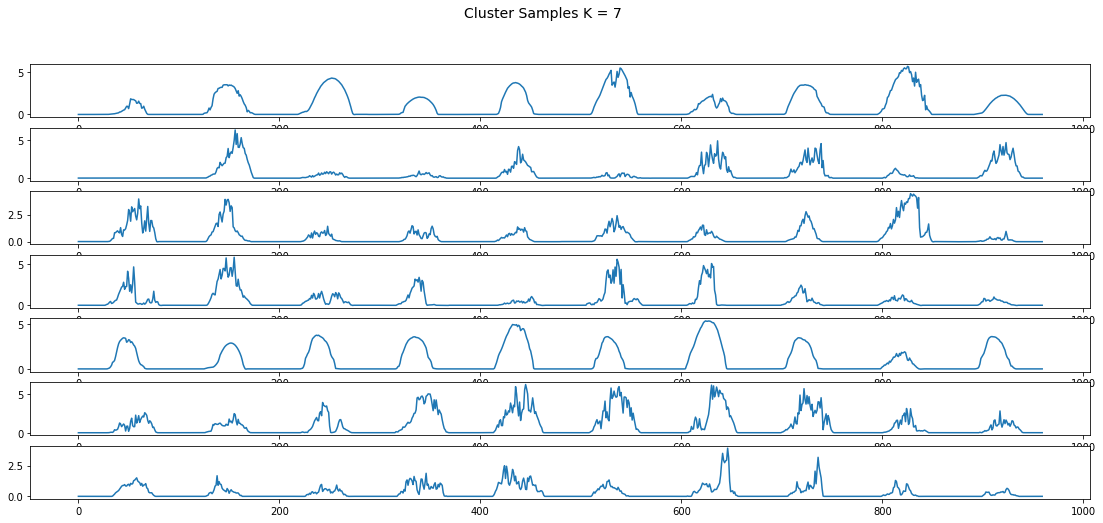

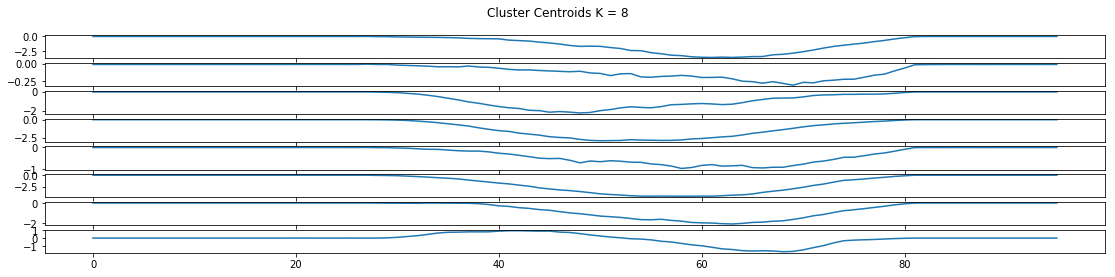

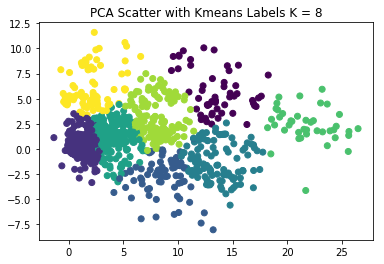

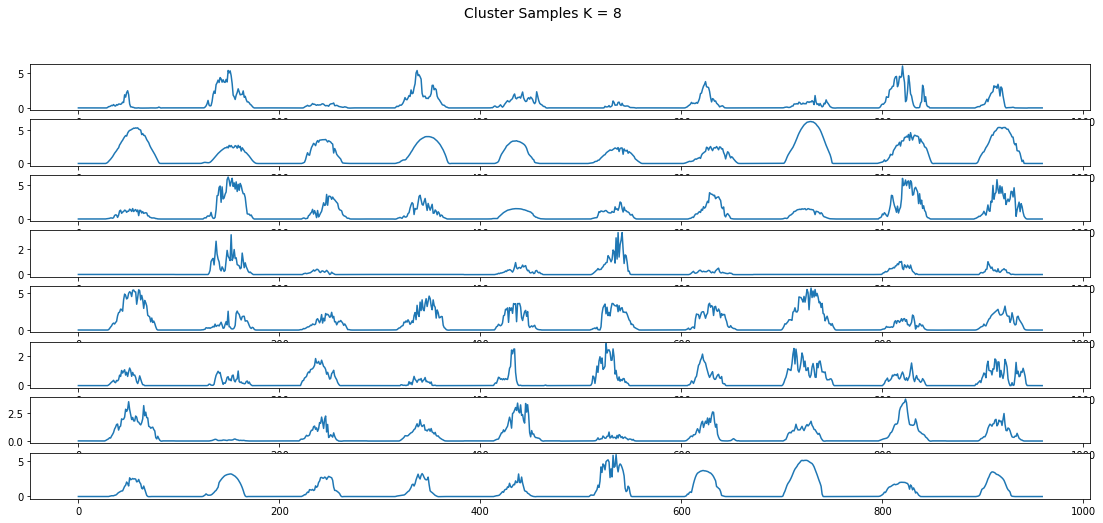

In [152]:
do_kmeans(delta_data, delta_proj)

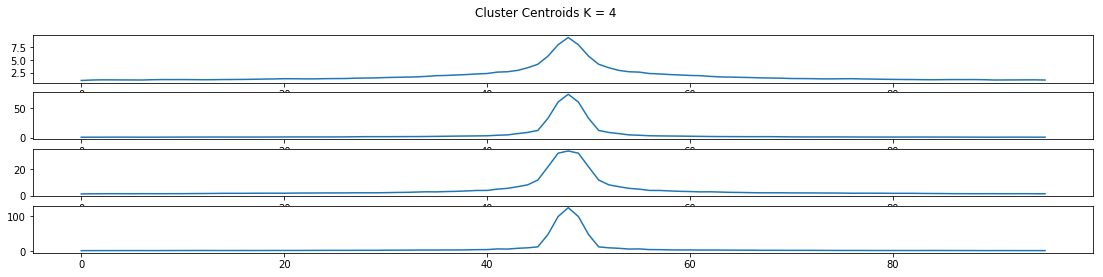

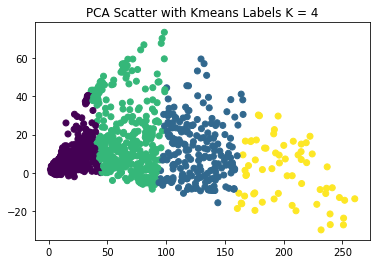

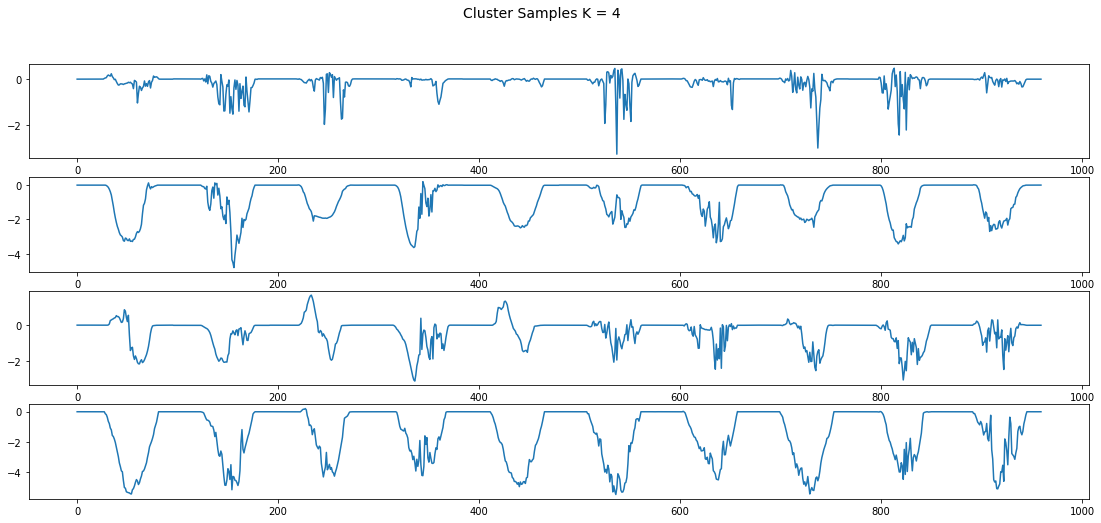

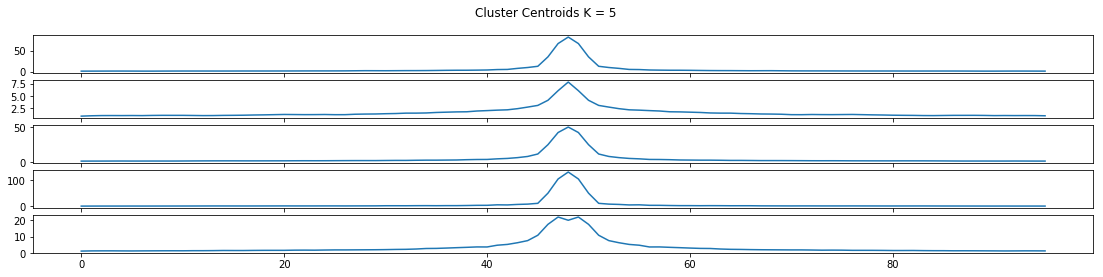

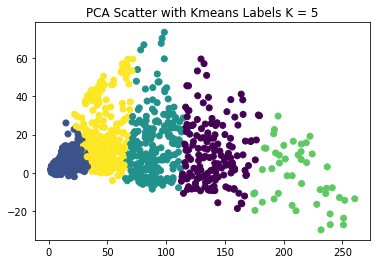

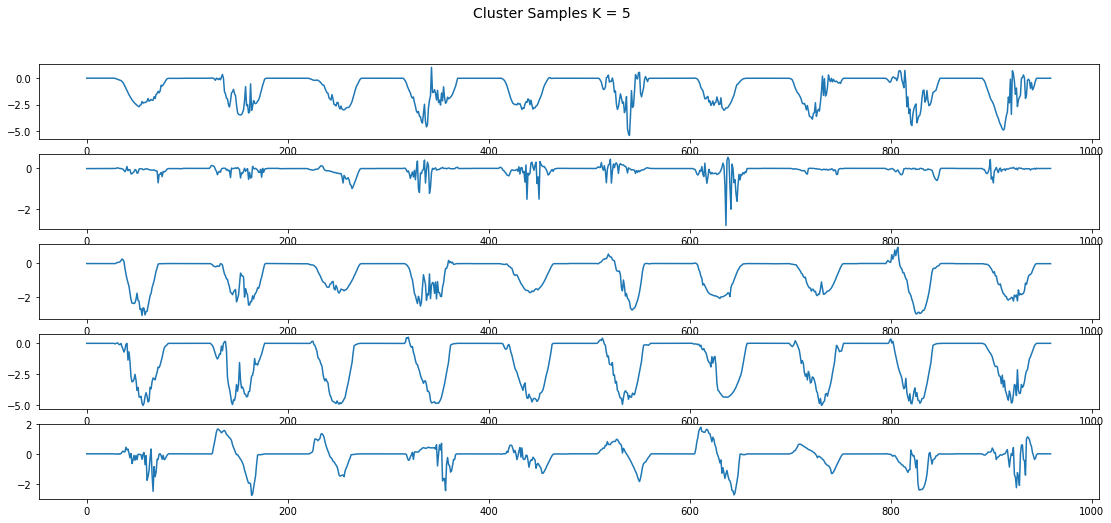

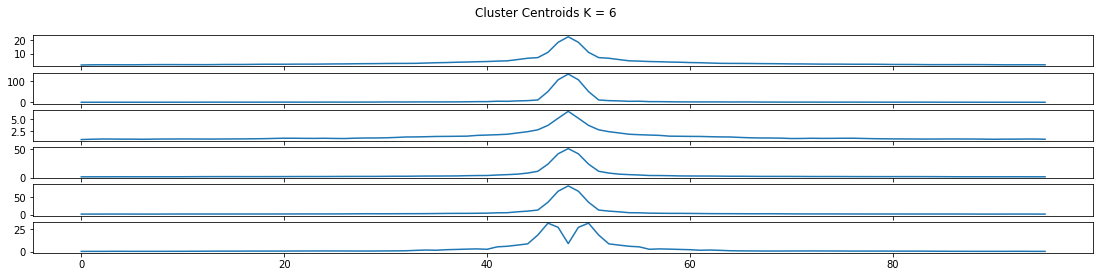

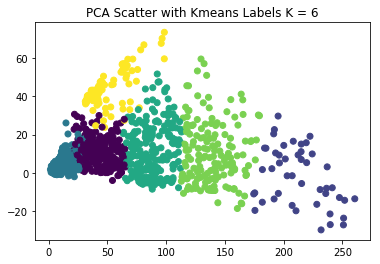

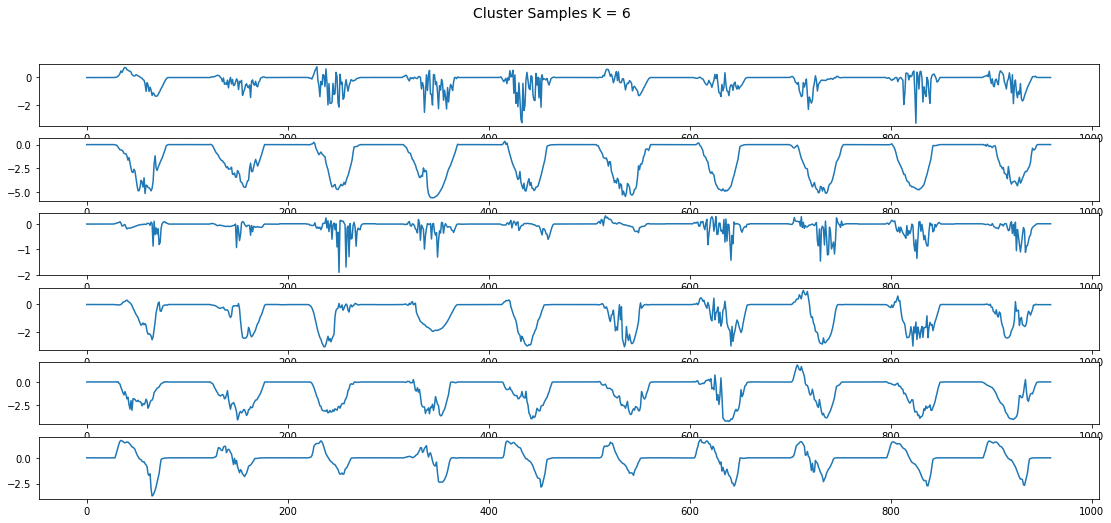

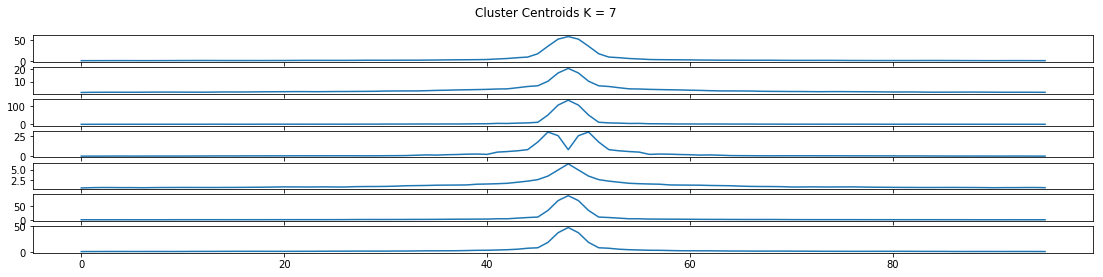

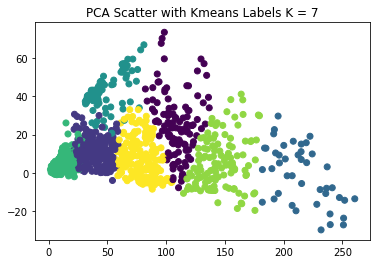

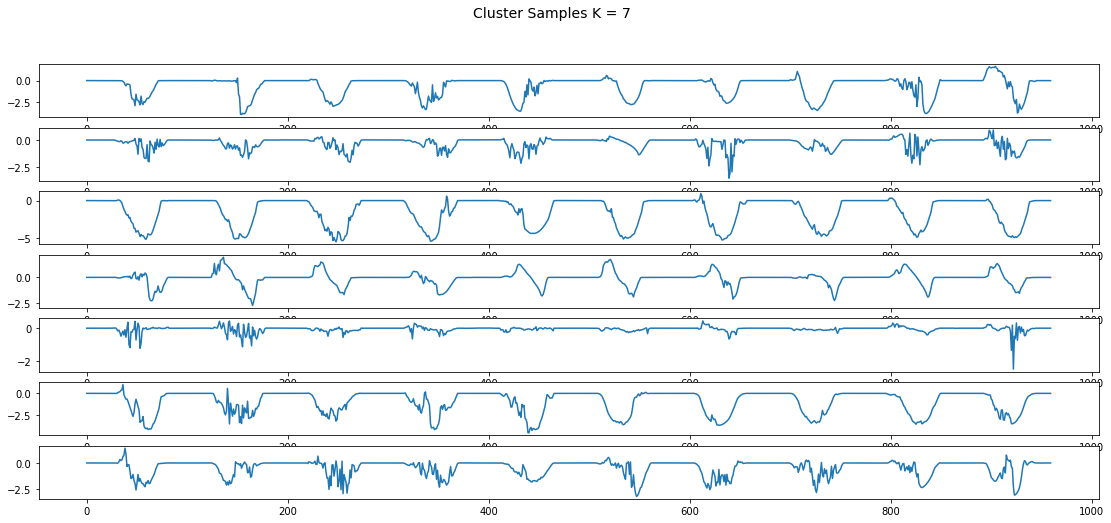

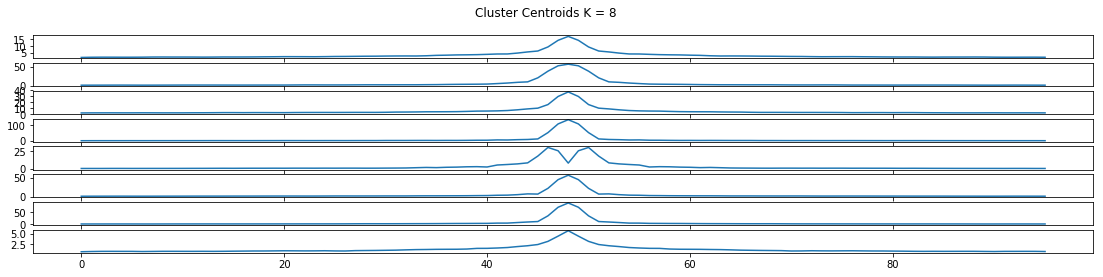

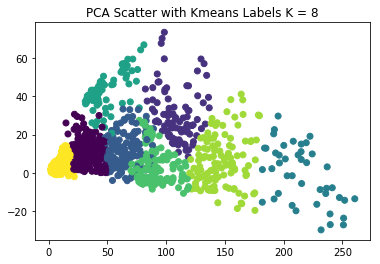

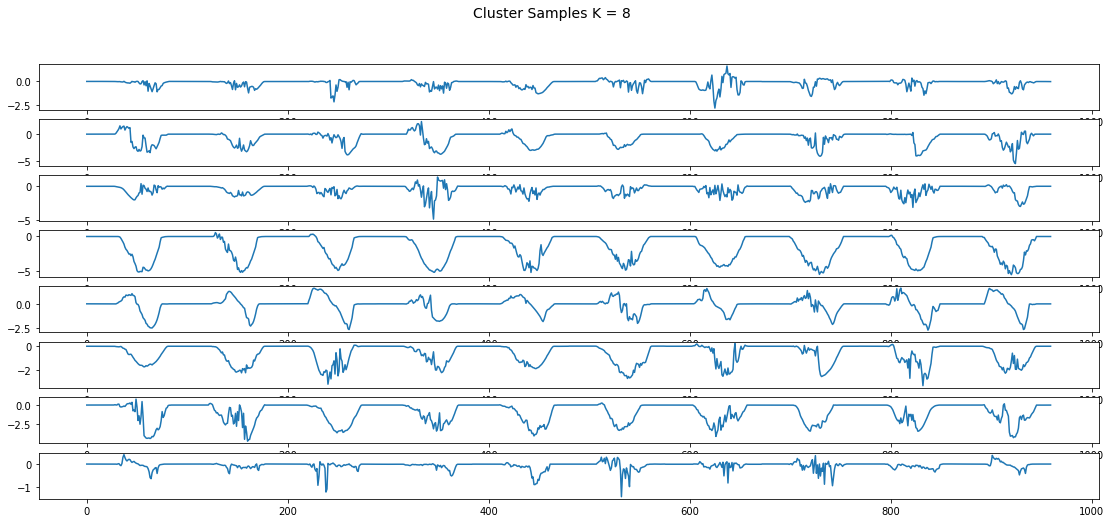

In [156]:
do_kmeans(freq_data, freq_proj)

## Agglomerative Clustering

Off the bat, agglomerative clustering with euclidean affinity and ward linkage seems to work very well for clustering data into similarly shaped days. It seems to have less of the problem that kmeans had, which was that it would cluster things together that had similar low-frequency shape (i.e. height) resulting in similarly smooth days being in separate clusters, and days with smooth and overcast parts being in the same cluster just because they were the same height. AgC seems to avoid that rather well.

Now to experiment with changing affinity and linkage to see if that does anything.

Another idea is to try high-pass filtering the data first, to remove the algorithms' ability to rely too strongly on the low-frequency content for clustering.

In [158]:
from sklearn.cluster import AgglomerativeClustering

In [180]:
def do_agglo_clustering(data, proj_data, n_clust_range=range(4,9), plot=True, plot_raw_data=False,
                       affinity='euclidean', linkage='ward'):
    '''
    Run agglomerative clustering on the data, using each value in n_clust_range as the number 
    of clusters to try. Then, plot the centroids, the PCA scatter with labels according to 
    the clustering, and random samples of the data from each cluster
    
    data is of shape (n_features, n_data_points), so cols are days and rows are time intervals
    
    For plotting, if plot_raw_data is true, the plots of samples from each cluster will be plots
    of the raw data (data without clearsky subtracted out)
    If plot_raw_data is false, then the samples plotted from each cluster will have the clearsky
    estimate subtracted out (i.e. it'll plot the delta_data instead)
    '''
    if np.iscomplex(data).any():
        data = np.abs(data)
        
    for n_clust in n_clust_range:
        agc = AgglomerativeClustering(n_clusters=n_clust, affinity=affinity, linkage=linkage).fit(data.T)

        # PCA scatter with colored labels
        plt.figure()
        plt.scatter(proj_data[0,:], proj_data[1,:], c=agc.labels_)
        plt.title('PCA Scatter with AggloCluster Labels K = ' + str(n_clust))
        plt.show()

        # Plot some random samples from each cluster
        plt.figure(figsize=(19,8))
        for i in range(n_clust):
            clust = np.argwhere(agc.labels_ == i).squeeze()
            samps = np.random.choice(clust, size=10, replace=True)
            if plot_raw_data:
                concat_samps = np.array([raw_data[:, s] for s in samps])
            else:
                concat_samps = np.array([delta_data[:, s] for s in samps])
            plt.subplot(n_clust, 1, i+1)
            plt.plot(concat_samps.ravel())
        plt.suptitle('Cluster Samples K = ' + str(n_clust), fontsize=14)
        plt.show()

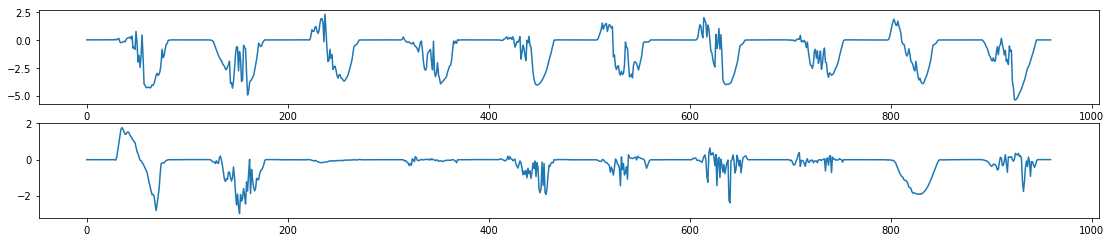

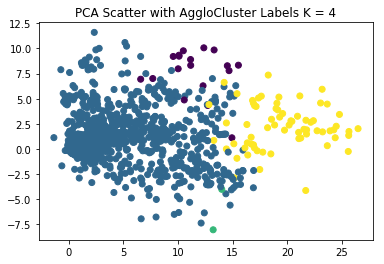

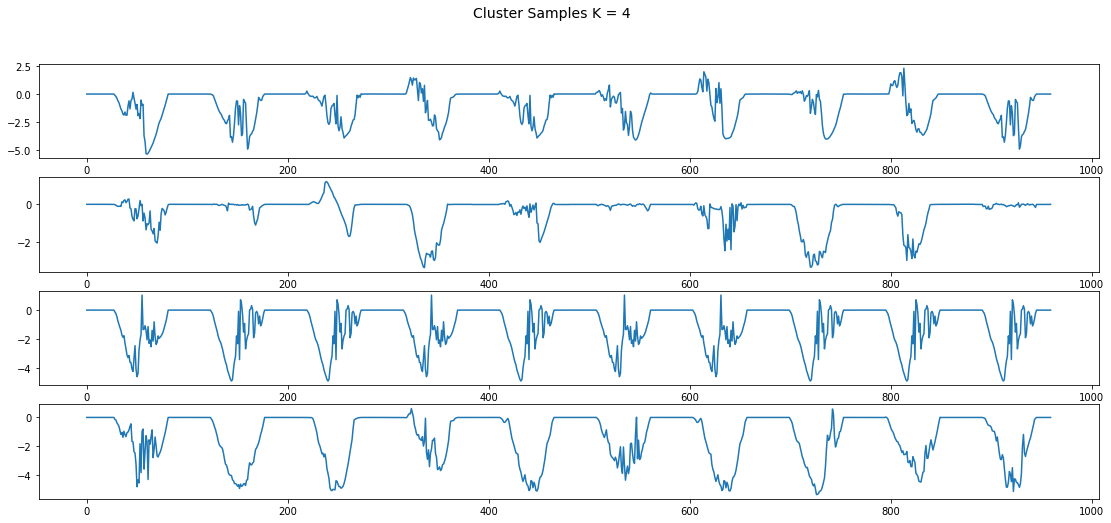

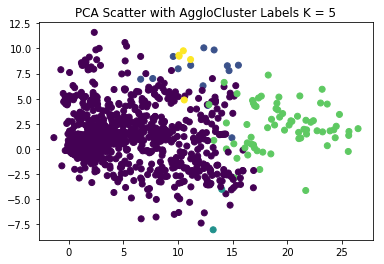

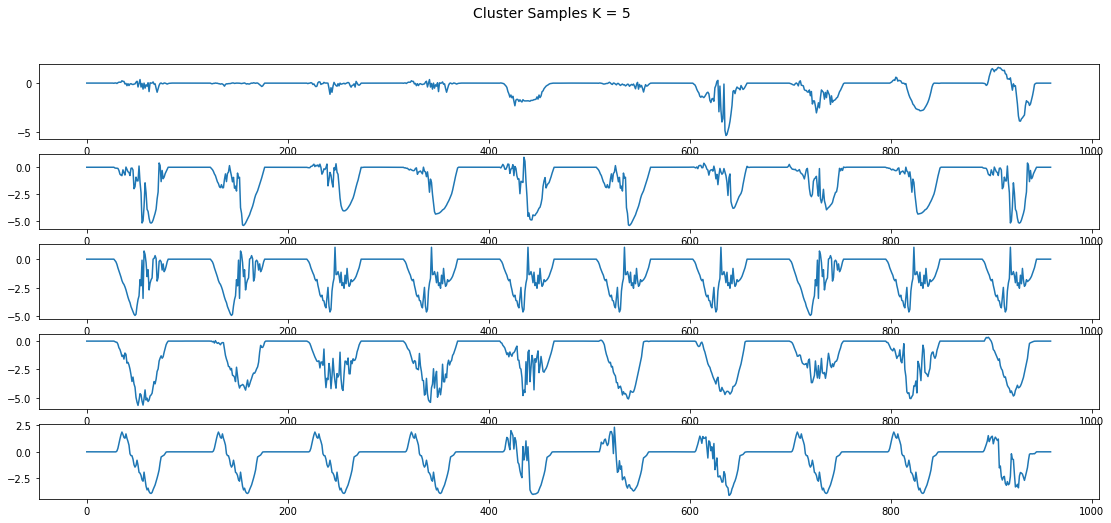

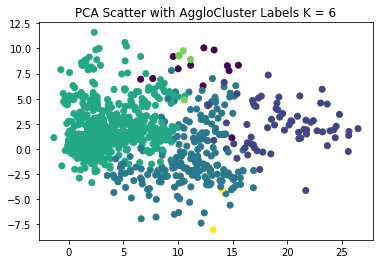

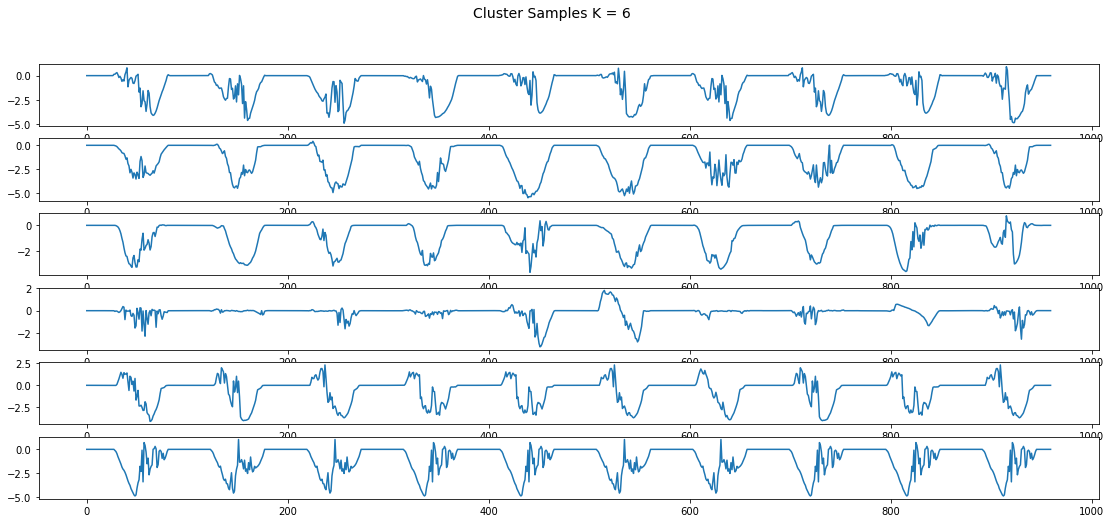

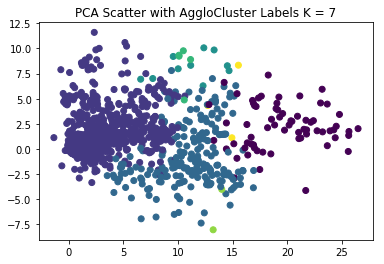

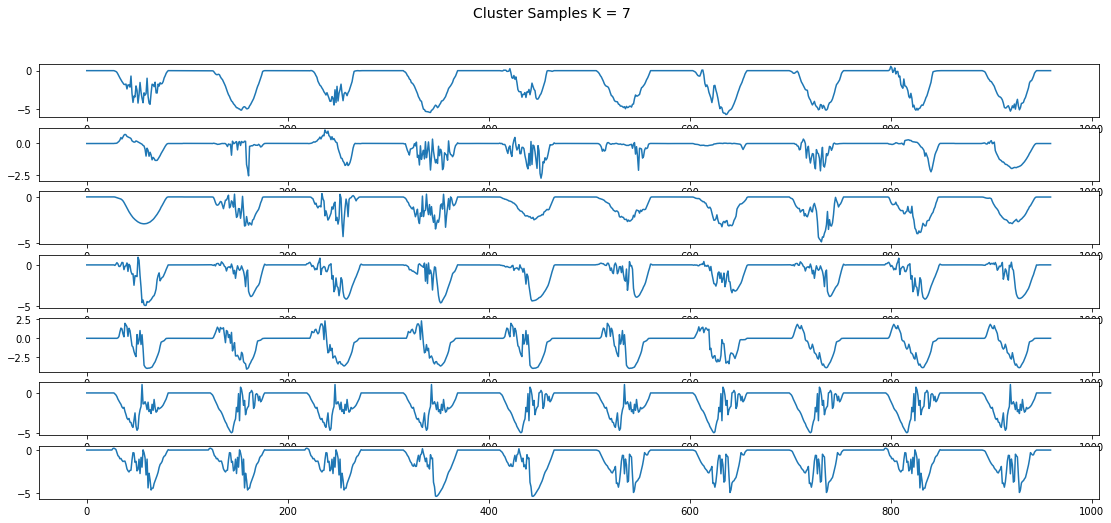

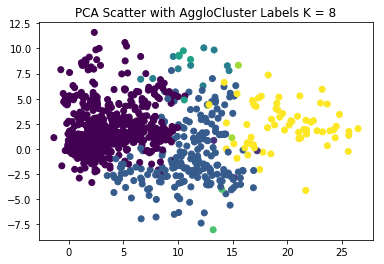

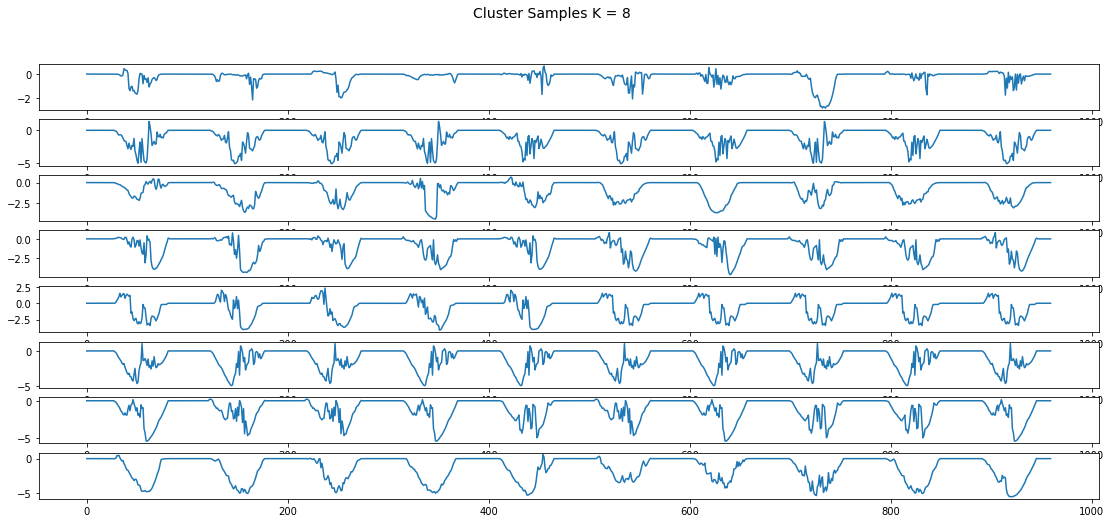

In [181]:
do_agglo_clustering(delta_data, delta_proj, affinity='l1', linkage='average')

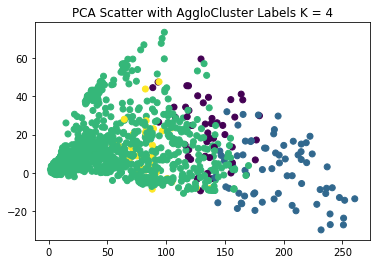

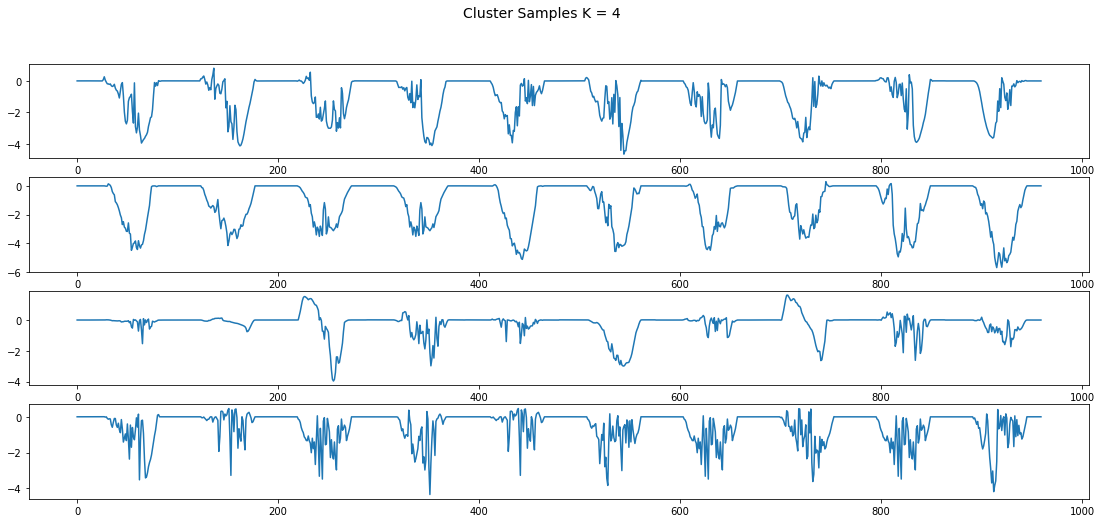

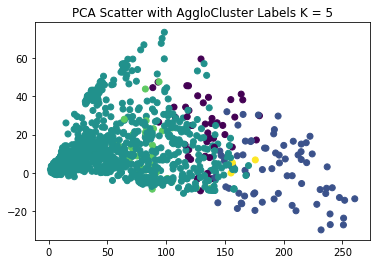

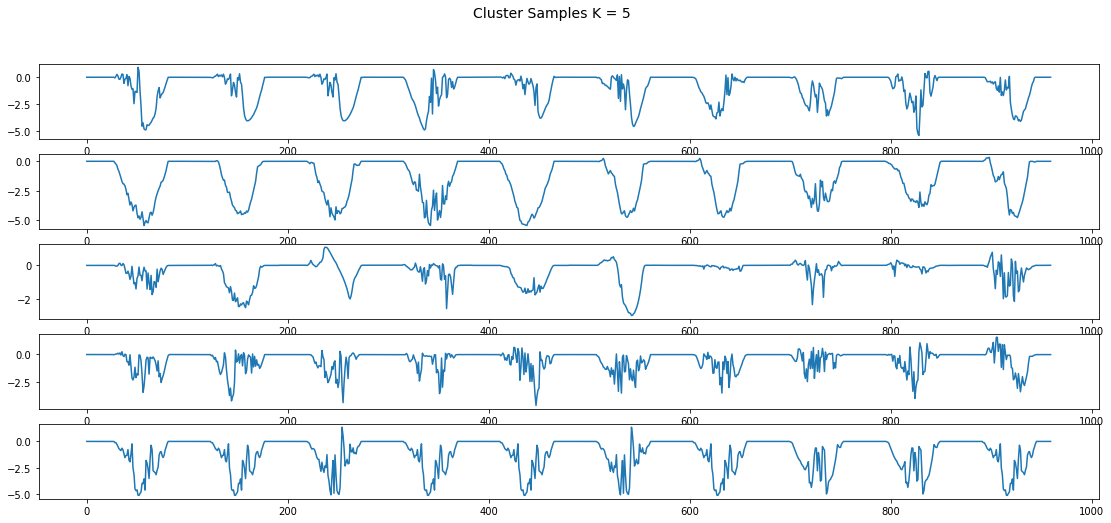

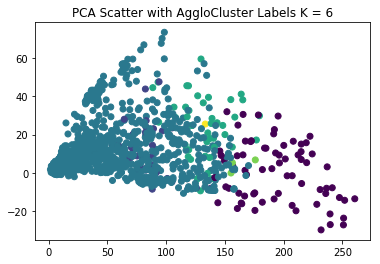

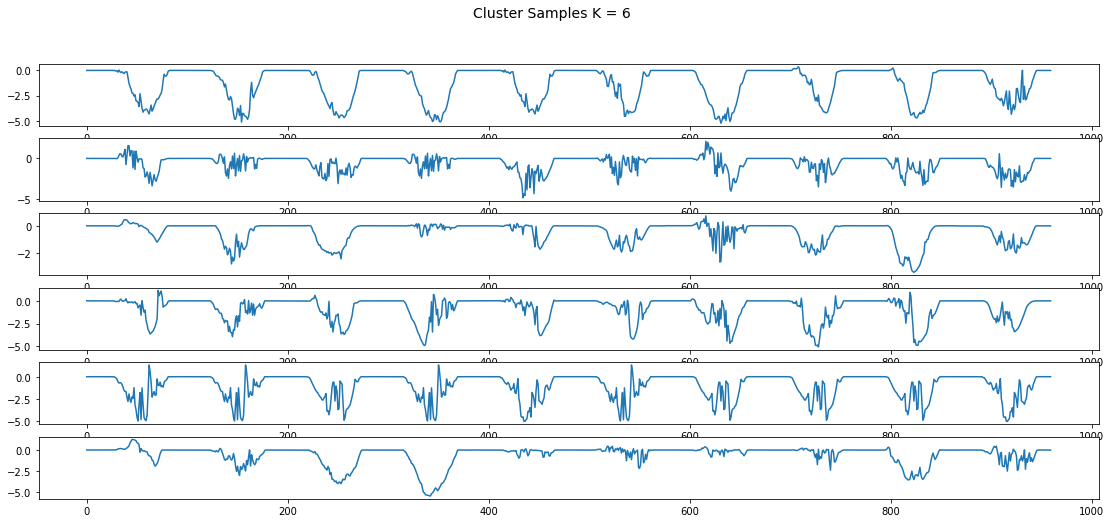

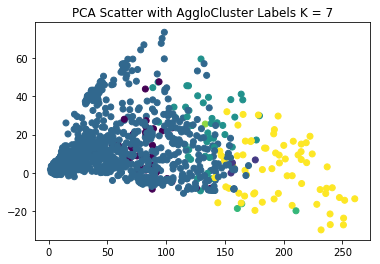

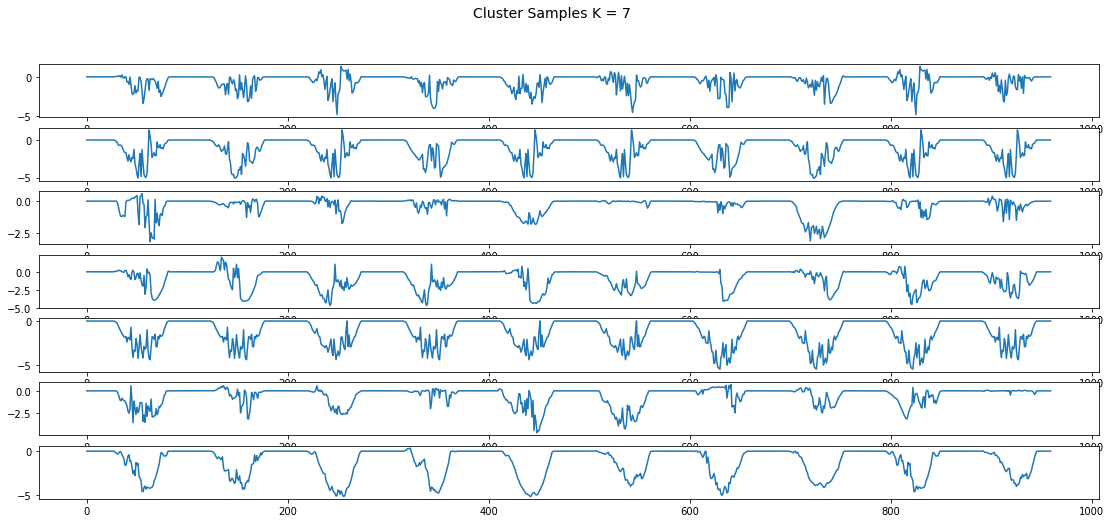

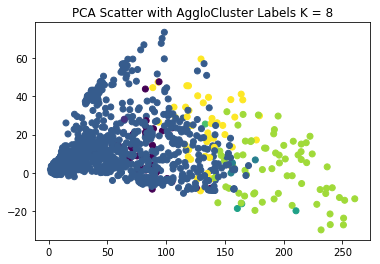

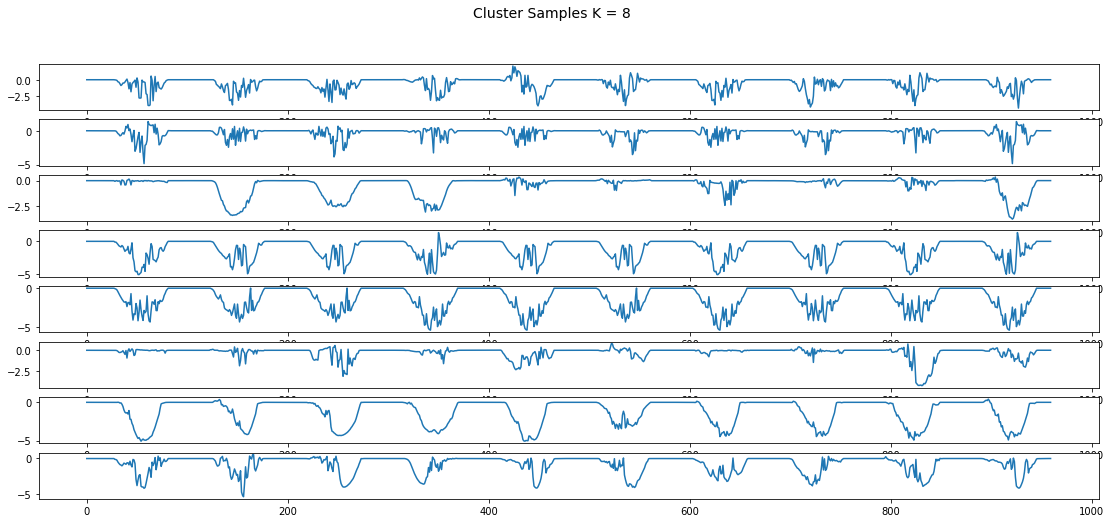

In [183]:
do_agglo_clustering(freq_data, freq_proj, affinity='l1', linkage='average')

## Gaussian Mixture

Gaussian Mixture sucks for the time domain data, but it seems to do alright on the frequncy data. The thing is, the means all look quite similar for the frequency data, and they just get steadily fatter tails is kinda all that's happening (except in the case where it has the dimple in the middle). Again, thinking if I high-pass filtered the data first, that might mitigate that problem.

In [207]:
from sklearn.mixture import GaussianMixture

In [208]:
def do_gaussian_mixture(data, proj_data, n_comp_range=range(4,9), plot=True, plot_raw_data=False):
    '''
    Cluster the data using gaussian mixture model, trying it with number of components equal to each
    value in n_comp_range.
    Then, plot the means from the learned distributions, the PCA scatter with labels according to 
    the clustering, and random samples of the data from each cluster
    
    data is of shape (n_features, n_data_points), so cols are days and rows are time intervals
    
    For plotting, if plot_raw_data is true, the plots of samples from each cluster will be plots
    of the raw data (data without clearsky subtracted out)
    If plot_raw_data is false, then the samples plotted from each cluster will have the clearsky
    estimate subtracted out (i.e. it'll plot the delta_data instead)
    '''
    if np.iscomplex(data).any():
        data = np.abs(data)

    for n_comp in n_comp_range:
        gmm = GaussianMixture(n_components=n_comp).fit(data.T)

        # Plot the means of each component
        plt.figure(figsize=(19,4))
        for i in range(n_comp):
            plt.subplot(n_comp, 1, i+1)
            plt.plot(gmm.means_[i,:])

        plt.suptitle('Distribution Means K = ' + str(n_comp))
        plt.show()

        # PCA scatter with colored labels
        labels = gmm.predict(data.T)
        plt.figure()
        plt.scatter(proj_data[0,:], proj_data[1,:], c=labels)
        plt.title('PCA Scatter with GMM Labels K = ' + str(n_comp))
        plt.show()

        # Plot some random samples from each cluster
        plt.figure(figsize=(19,8))
        for i in range(n_comp):
            clust = np.argwhere(labels == i).squeeze()
            samps = np.random.choice(clust, size=10, replace=False)
            if plot_raw_data:
                concat_samps = np.array([raw_data[:, s] for s in samps])
            else:
                concat_samps = np.array([delta_data[:, s] for s in samps])
            plt.subplot(n_comp, 1, i+1)
            plt.plot(concat_samps.ravel())
        plt.suptitle('Cluster Samples K = ' + str(n_comp), fontsize=14)
        plt.show()


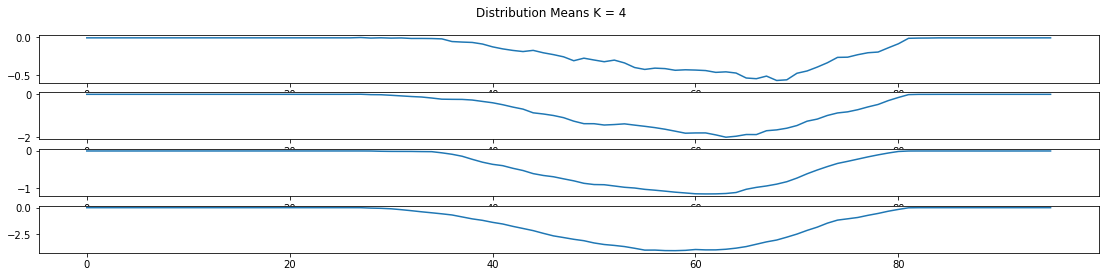

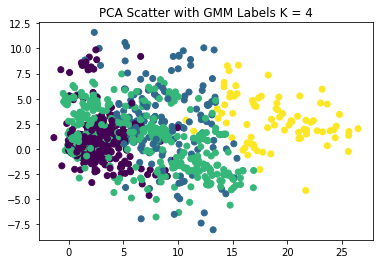

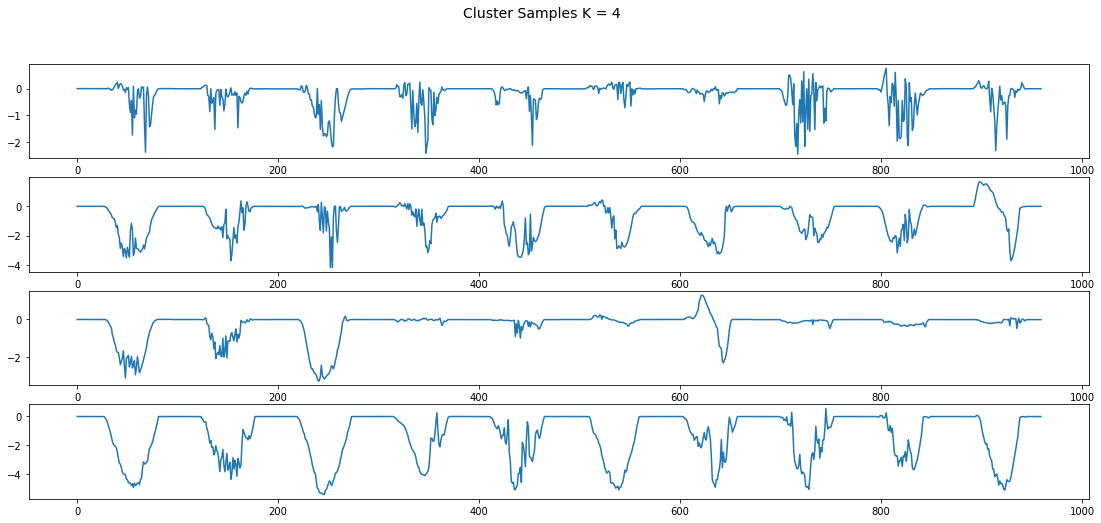

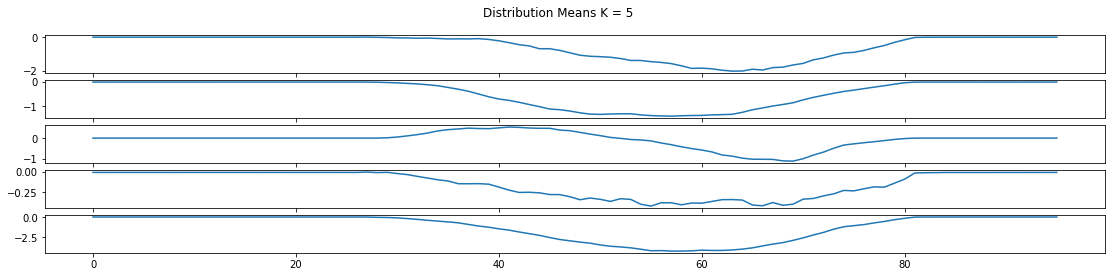

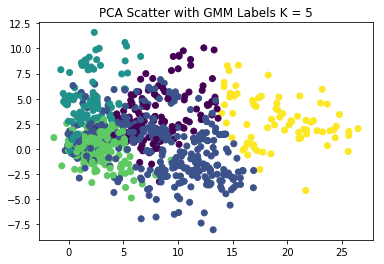

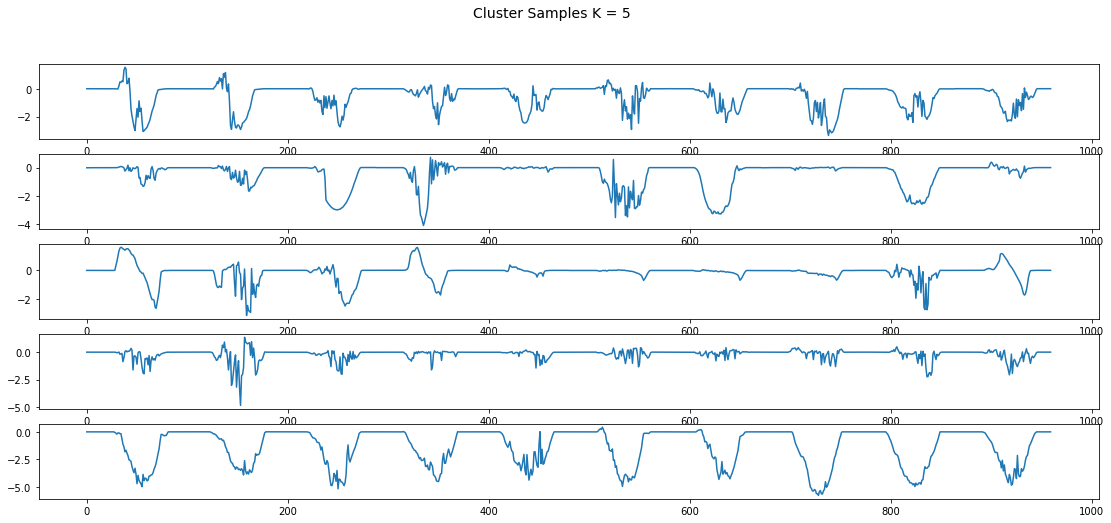

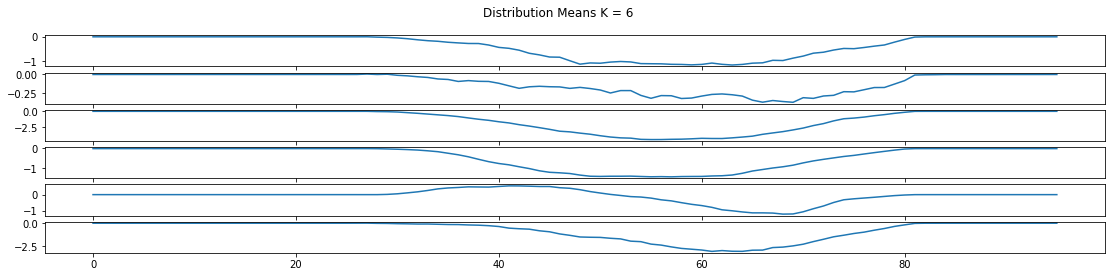

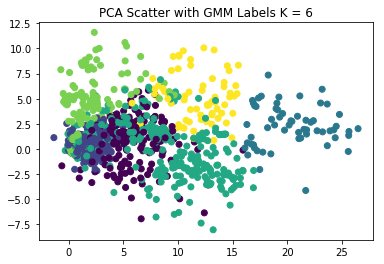

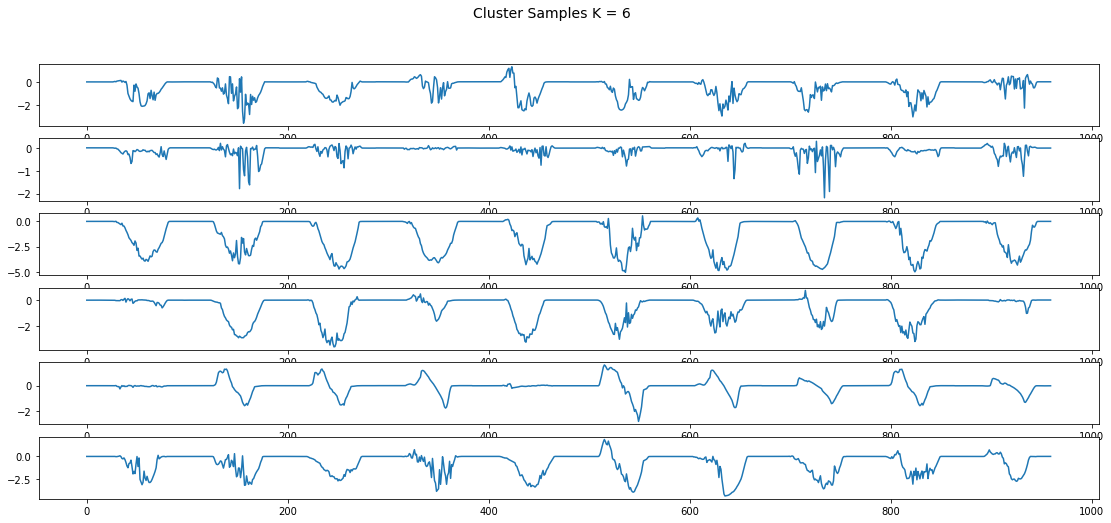

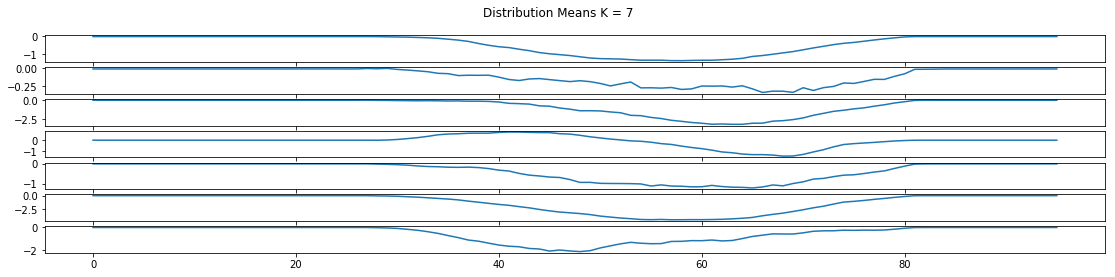

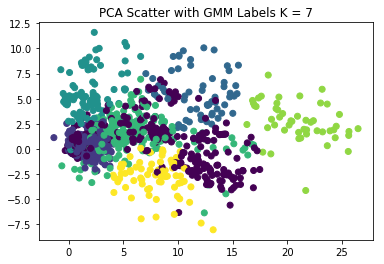

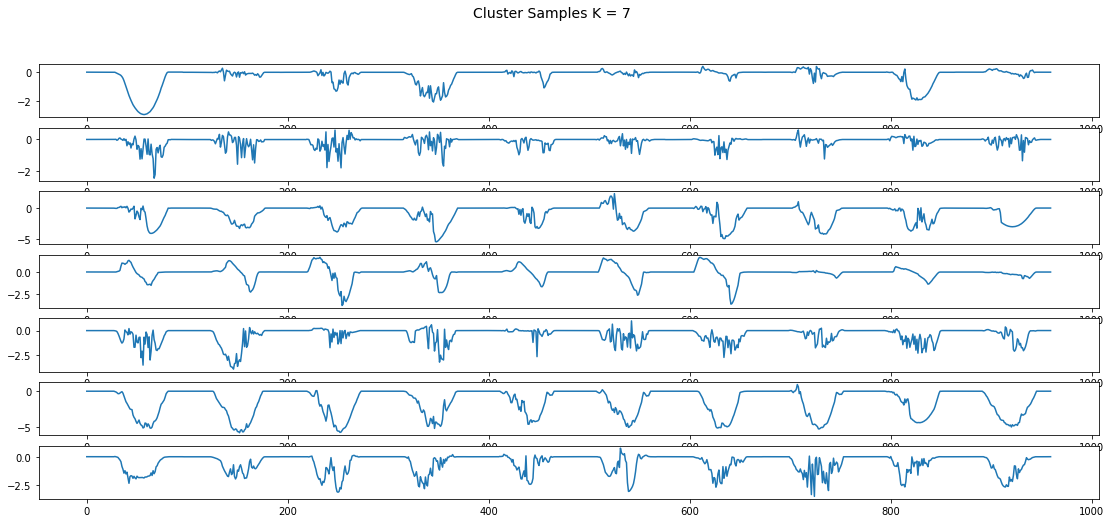

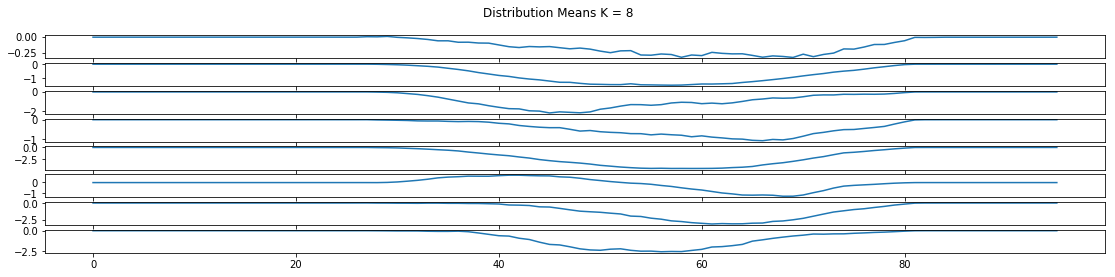

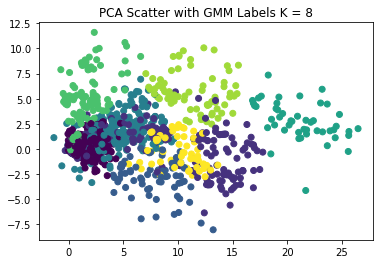

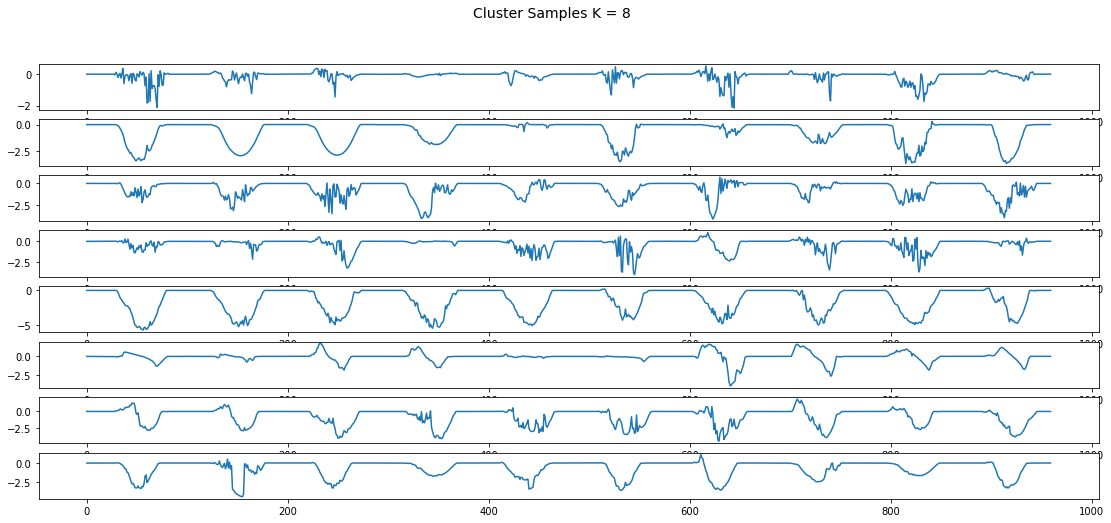

In [209]:
do_gaussian_mixture(delta_data, delta_proj)

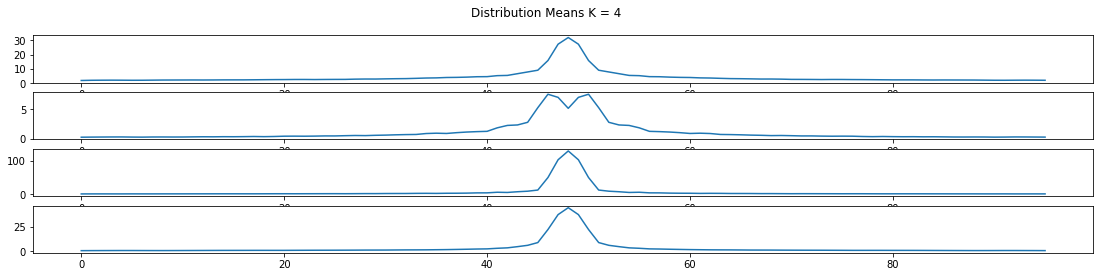

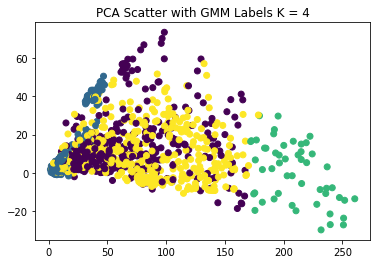

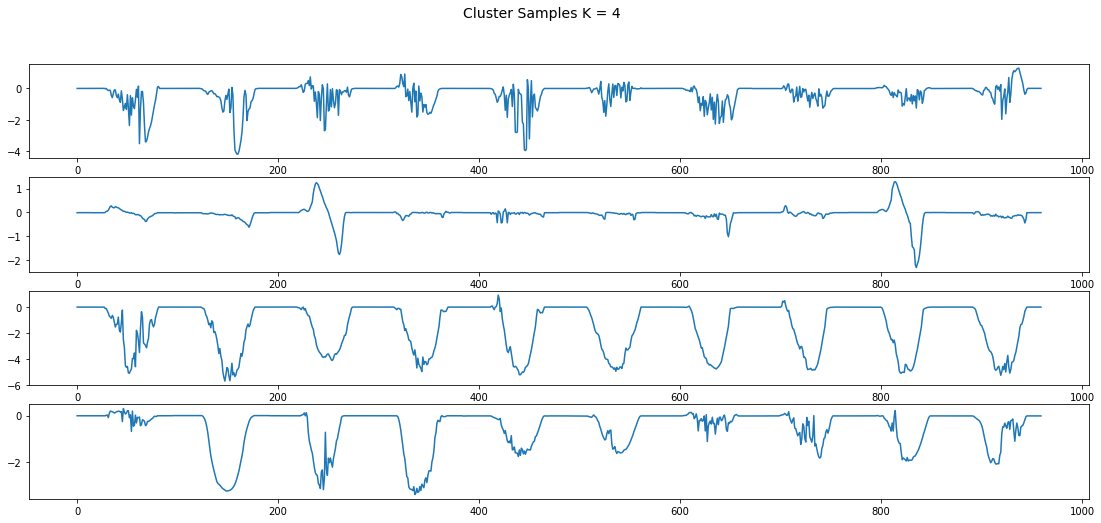

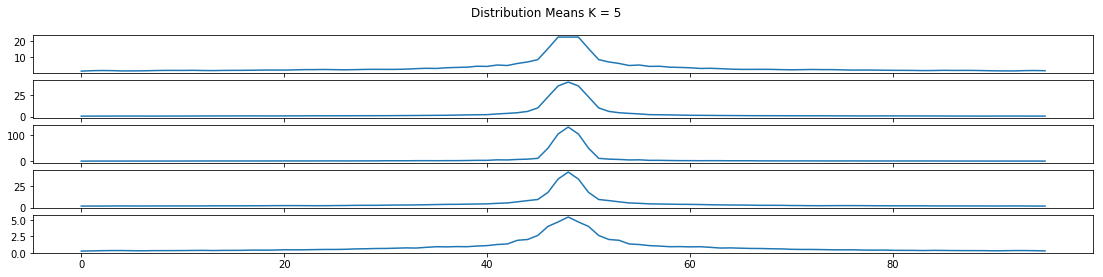

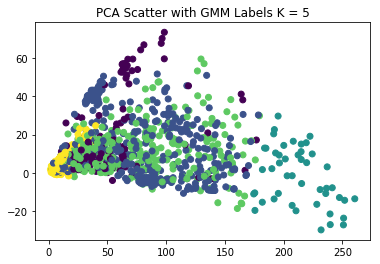

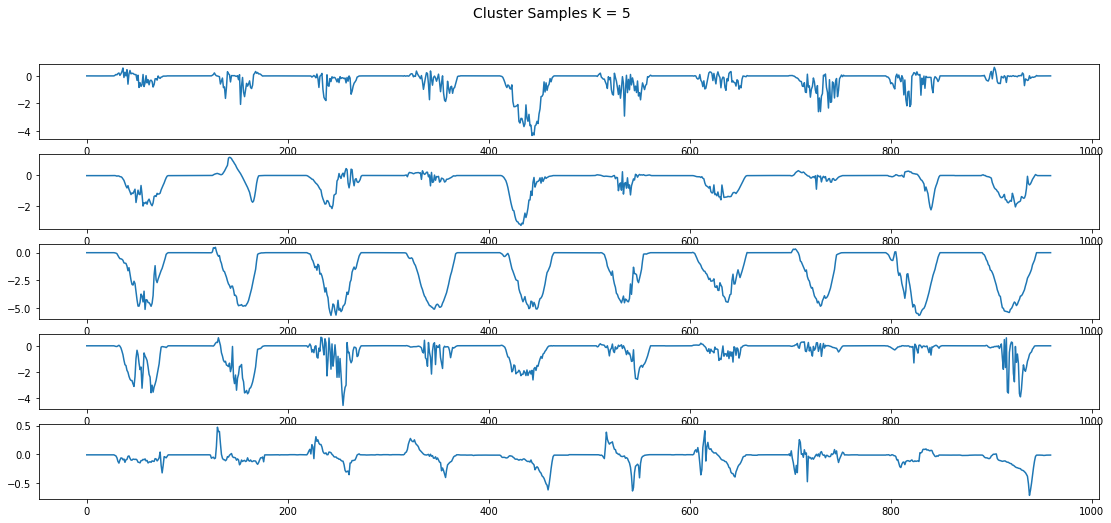

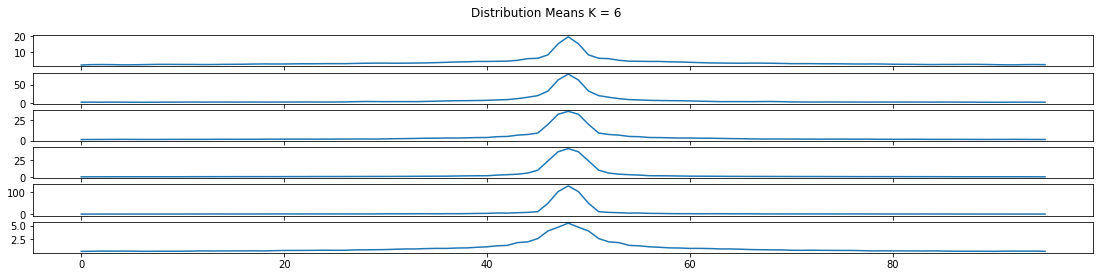

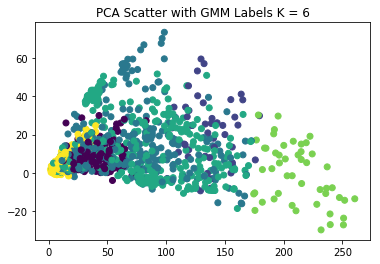

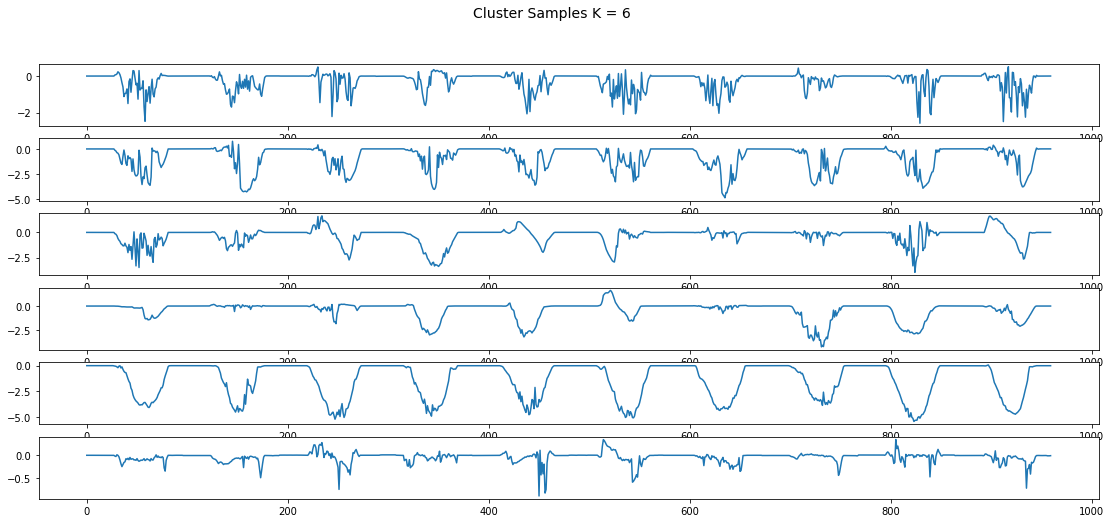

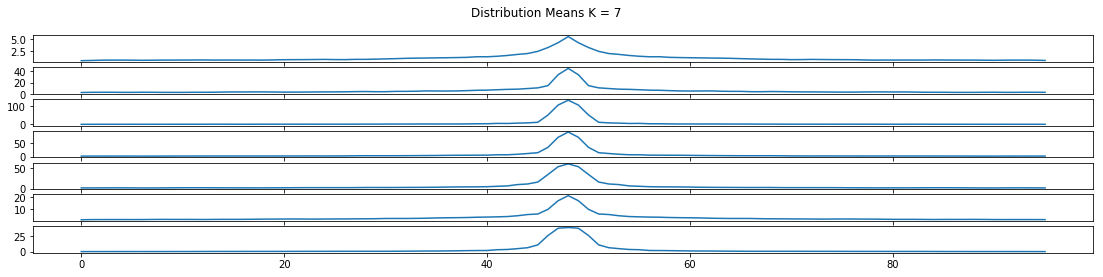

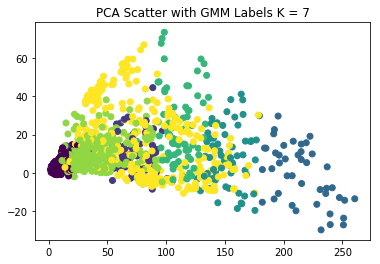

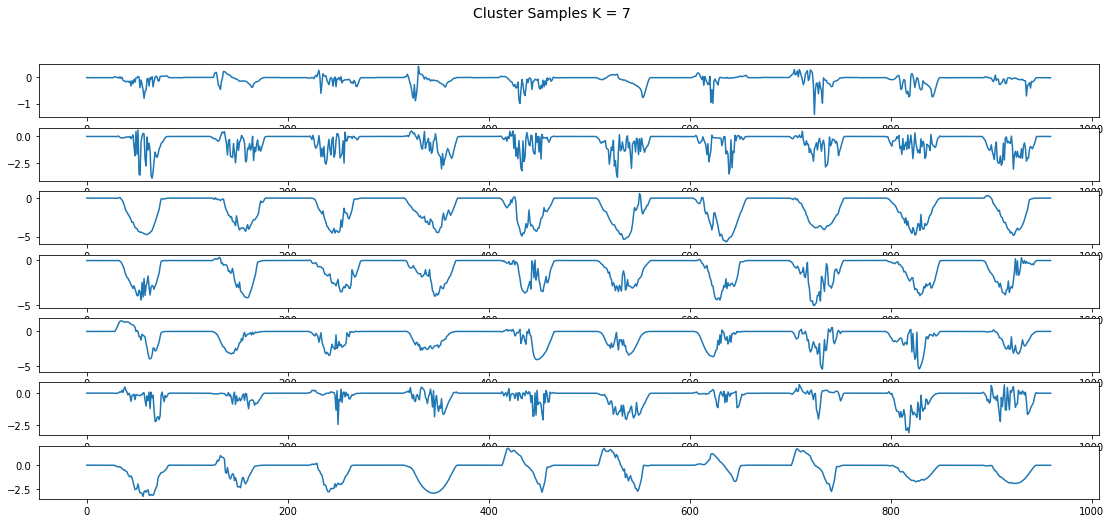

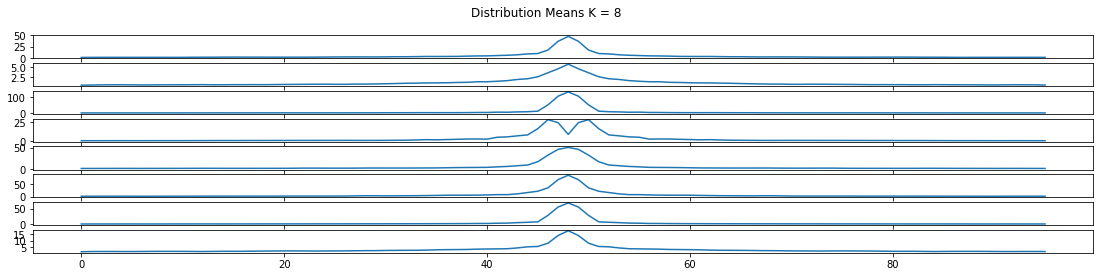

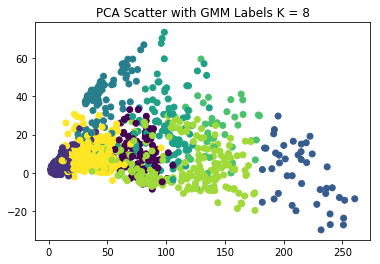

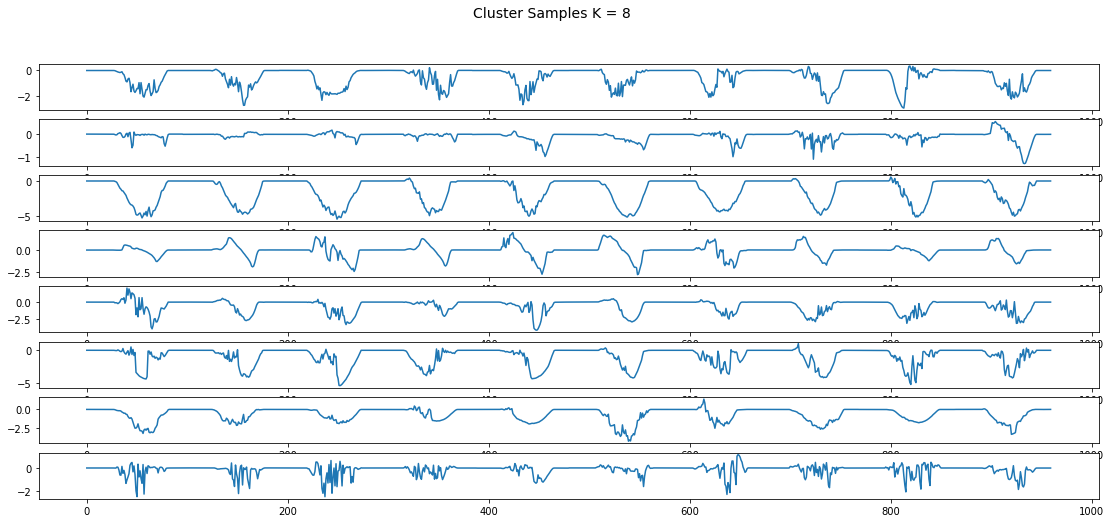

In [210]:
do_gaussian_mixture(freq_data, freq_proj)

### Spectral Clustering

#  I think there's missing data in solar_home 3

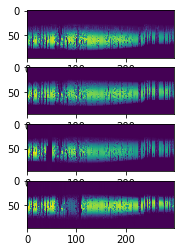

In [192]:
plt.subplot(4,1,1)
plt.imshow(daily_mat[:, :num_days])
plt.subplot(4,1,2)
plt.imshow(daily_mat[:, num_days:num_days*2])
plt.subplot(4,1,3)
plt.imshow(daily_mat[:, num_days*2:num_days*3])
plt.subplot(4,1,4)
plt.imshow(daily_mat[:, num_days*3:])

plt.show()